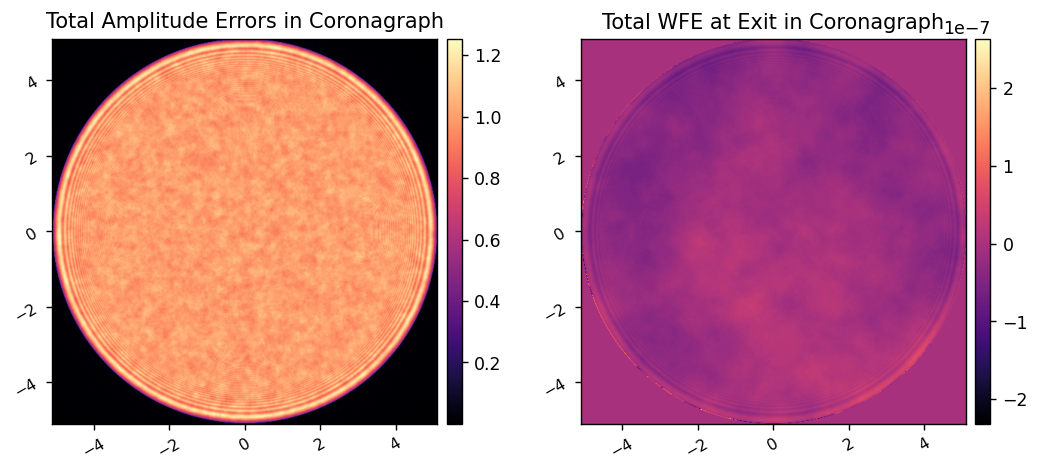

In [35]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
import subprocess

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fraunhofer_coro_poppy as fraunhofer
from apra_pop_models.math_module import xp, _scipy, ensure_np_array

import apra_pop_models.efc as efc
import apra_pop_models.efc_embedded as efc
import apra_pop_models.pwp as pwp
import apra_pop_models.pwp_embedded as pwp
import apra_pop_models.efc_utils as efc_utils

from apra_pop_models.imshows import *

pupil_diam = 10.2*u.mm
wavelength_c = 650e-9*u.m

focal_ratio = 350/500 # focal lengths of relay OAPs from DM pupil to 
lyot_diam = 0.85 * pupil_diam *focal_ratio

# Load in the pupil plane wfe from the compact model of the coronagraph
wfe_fits = fits.open('../phase-retrieval-data/post_fpm_wfe_20231109.fits')
coro_wfe = wfe_fits[0].data
wfe_pxscl = wfe_fits[0].header['PIXELSCL'] * u.m/u.pix
wfe_fits.close()
CORO_WFE = poppy.ArrayOpticalElement(transmission=coro_wfe[0], opd=coro_wfe[1],pixelscale=wfe_pxscl,)
imshow2(CORO_WFE.amplitude, CORO_WFE.opd, 
        'Total Amplitude Errors in Coronagraph', 'Total WFE at Exit in Coronagraph',
        pxscl=CORO_WFE.pixelscale.to(u.mm/u.pix))

vortex_model = apra_pop_models.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)
lyot_stop_model = poppy.CircularAperture(radius=lyot_diam/2 / focal_ratio)


# Test the match between the full model and the compact model

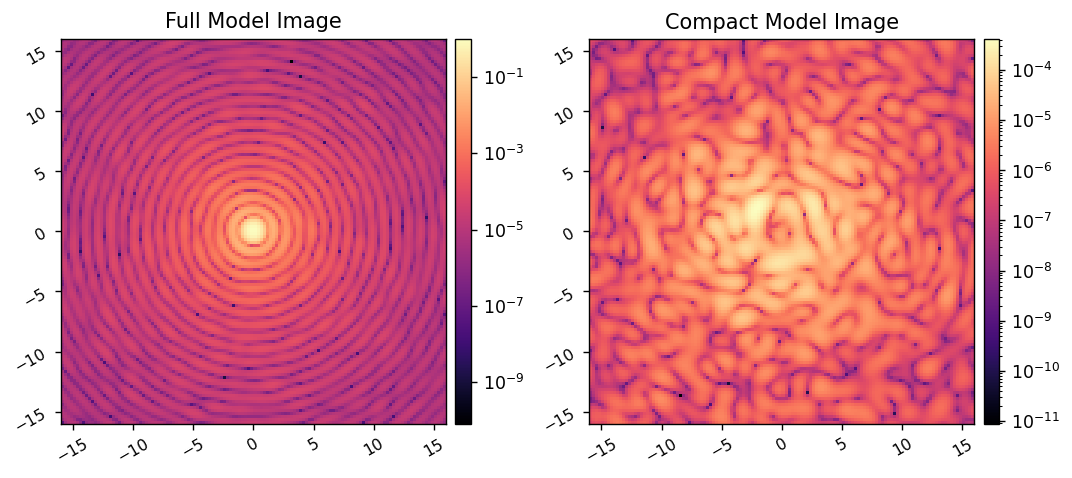

In [2]:
reload(fraunhofer)
reload(apra_pop_models.dm)
reload(apra_pop_models.agpm)

model = fraunhofer.CORO()
model.npix = 128
model.oversample = 16
model.npsf = 128
model.RETRIEVED = CORO_WFE

model.im_norm = model.snap().max()

model_psf = model.snap()

model.FPM = vortex_model
model.LYOT = lyot_stop_model

model_im = model.snap()

imshow2(model_psf, model_im, 'Full Model Image', 'Compact Model Image', lognorm=True,
        pxscl=model.psf_pixelscale_lamD)

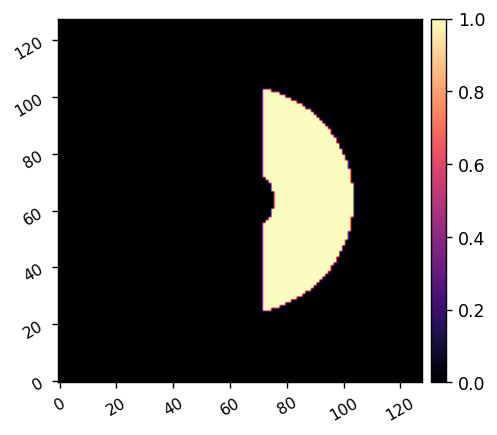

1828


In [3]:
control_mask = efc_utils.create_annular_focal_plane_mask(model, inner_radius=3, outer_radius=10, edge=2, plot=True)

Nmask = int(control_mask.sum())
print(Nmask)

In [7]:
poke_modes = efc_utils.create_all_poke_modes(model.dm_mask)

Calculating Jacobian: 
	Calculated response for mode 952/952. Elapsed time=274.059 sec.
Jacobian built in 274.059 sec


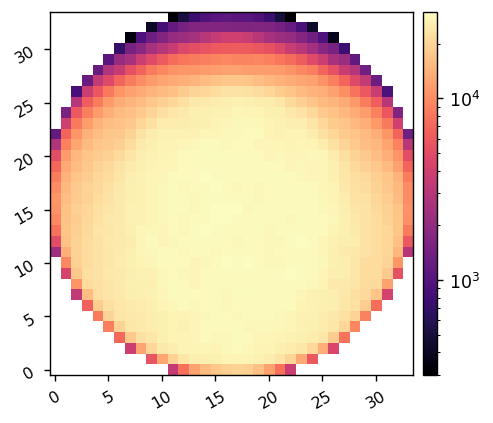

In [13]:
model.reset_dm()
coro.reset_dm()

amp = 1e-9 # poke amplitudes (DM surface)
jac = efc.calibrate(model, poke_modes, amp, control_mask, plot=True)

In [ ]:
utils.save_fits('../jacobians/jac_20231115.fits', jac)

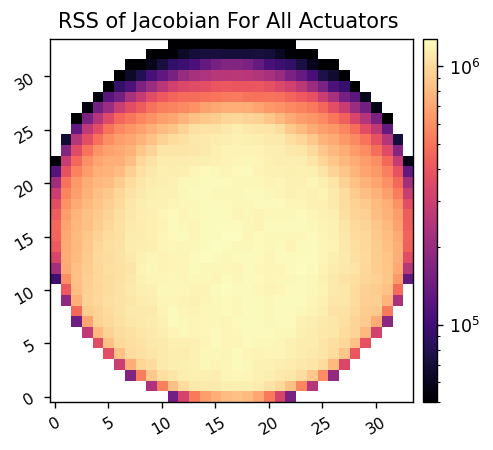

In [8]:
jac = xp.array(fits.getdata('../jacobians/jac_20231115.fits'))

responses = jac[::2] + 1j*jac[1::2]
response = xp.sqrt(xp.sum(abs(responses.dot(xp.array(poke_modes)))**2, axis=0)).reshape(model.Nact,model.Nact)
imshow1(response, 'RSS of Jacobian For All Actuators ', lognorm=True, vmin=5e4)

# Run EFC on the compact model with perfect E-Field estimation


In [9]:
model.reset_dm()

images = xp.array([model_im])
dm_commands = xp.array([model.get_dm()])

In [10]:
# import apra_pop_models.efc as efc
import apra_pop_models.efc_embedded as efc
import apra_pop_models.pwp_embedded as pwp
reload(efc)

<module 'apra_pop_models.efc_embedded' from '/home/apra/Projects/apra-howfsc-models/apra_pop_models/efc_embedded.py'>

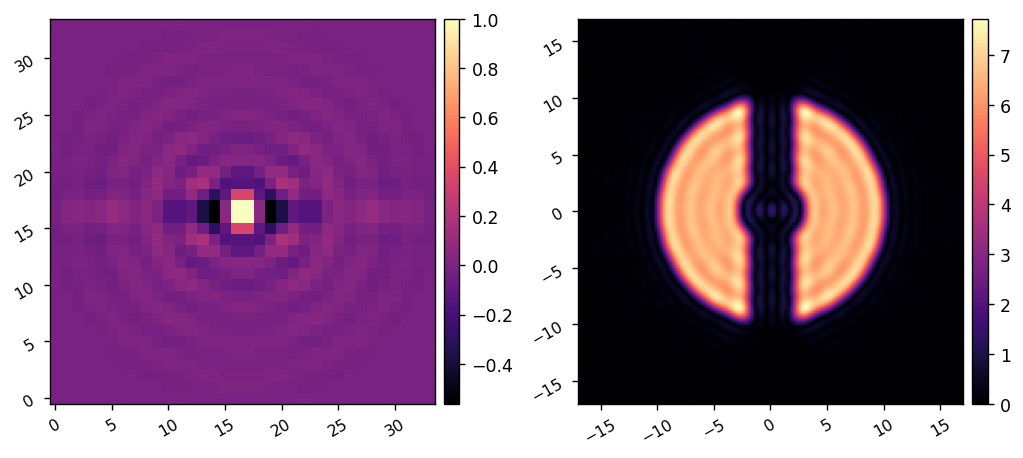

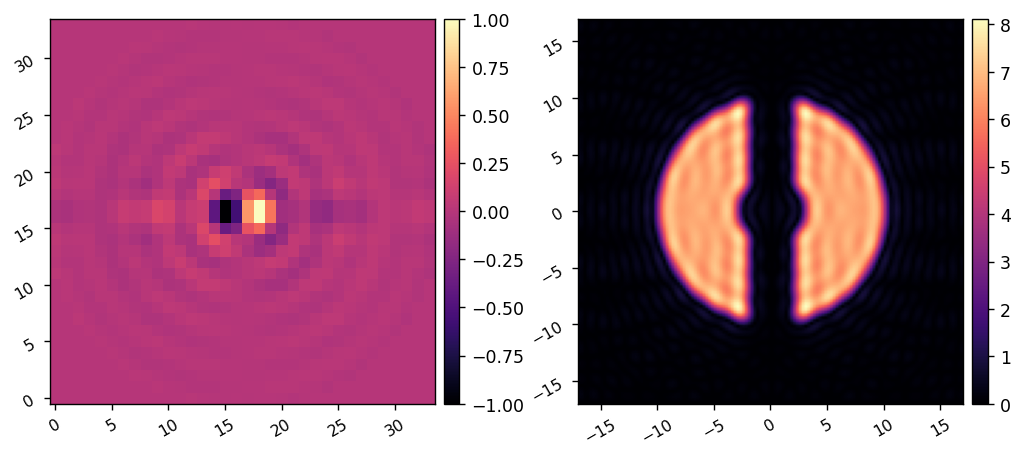

In [11]:
reload(efc_utils)
probe_modes = efc_utils.create_fourier_probes(model, control_mask, nprobes=2, plot=True, calc_responses=True)
# imshow3(sin_probes[0], sin_probes[1], sin_probes[2])
# imshow2(sin_probes[0], sin_probes[1])

In [15]:
import sys
# sys.path.insert(len(sys.path), 'home/apra/Projects/P5040/P5040_test_software/EFC/python_host')
sys.path.insert(len(sys.path), '/home/apra/Projects/P5040/P5040_test_software/EFC/python_host')

In [36]:
import efc_host_utils
embedded_controller = efc_host_utils.EmbeddedController()

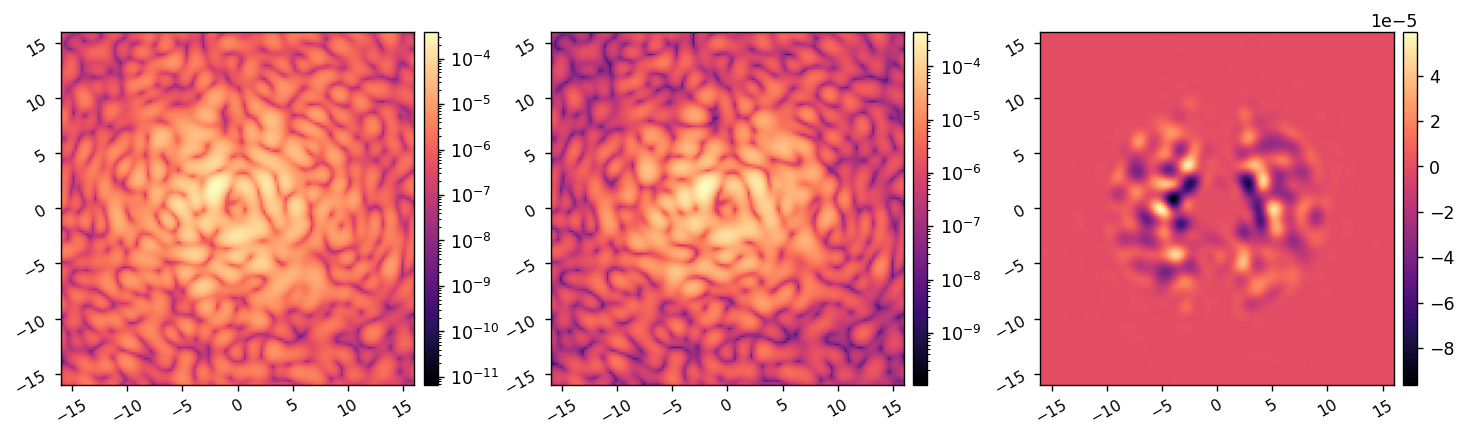

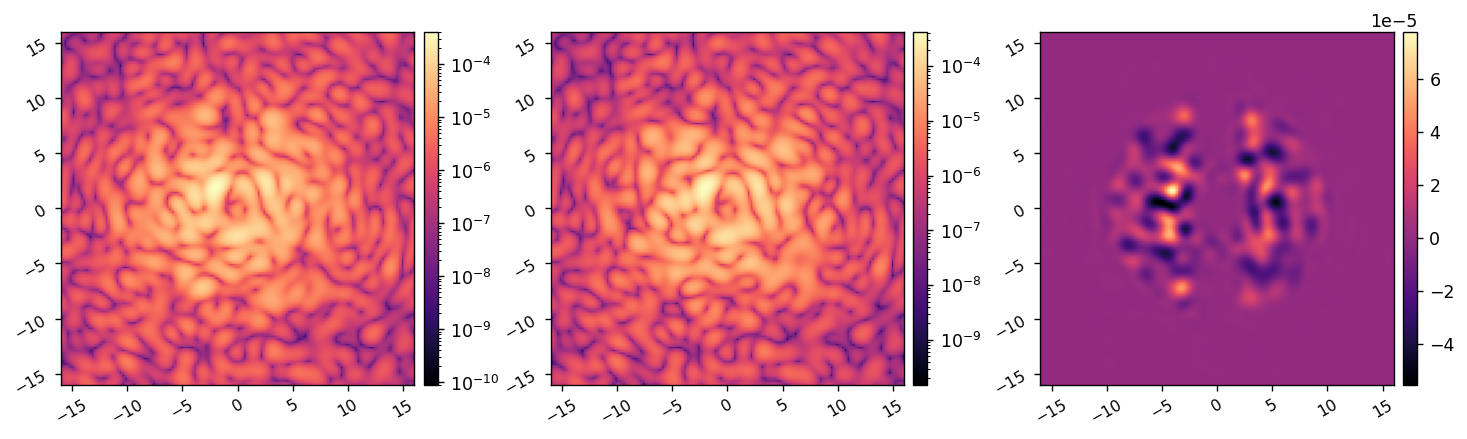

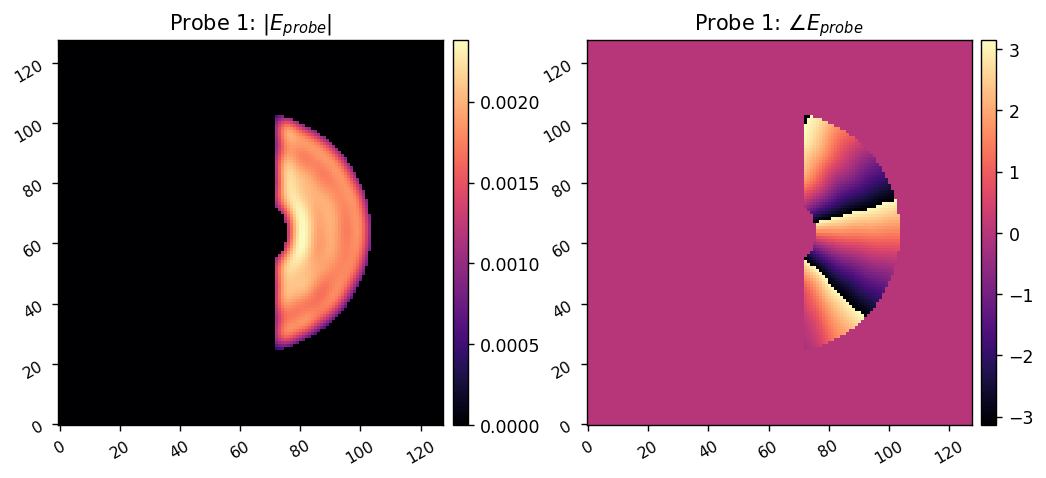

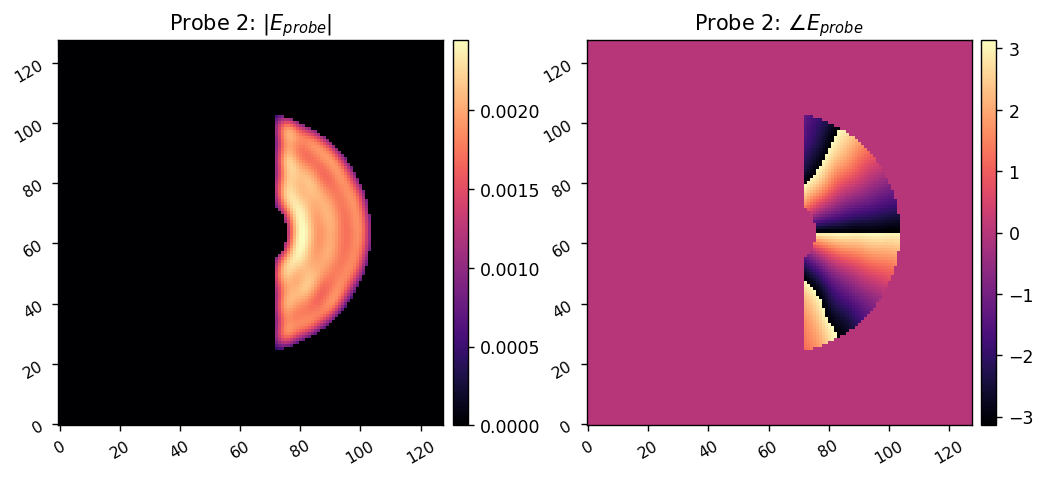

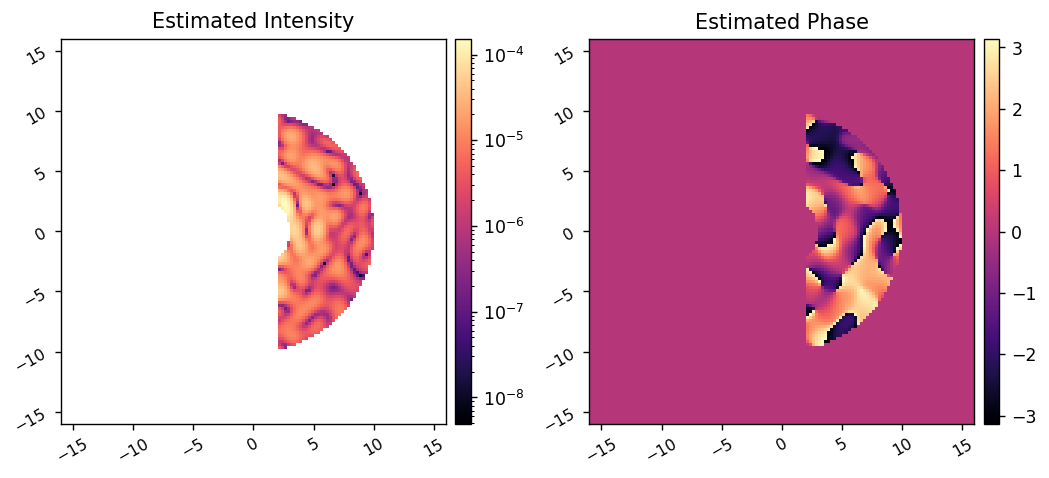

In [29]:
reload(pwp)
model.reset_dm()

probe_amp = 10e-9
est = pwp.run_pwp_bp(model, control_mask, probe_amp*probe_modes, jac, embedded_controller, plot=True)

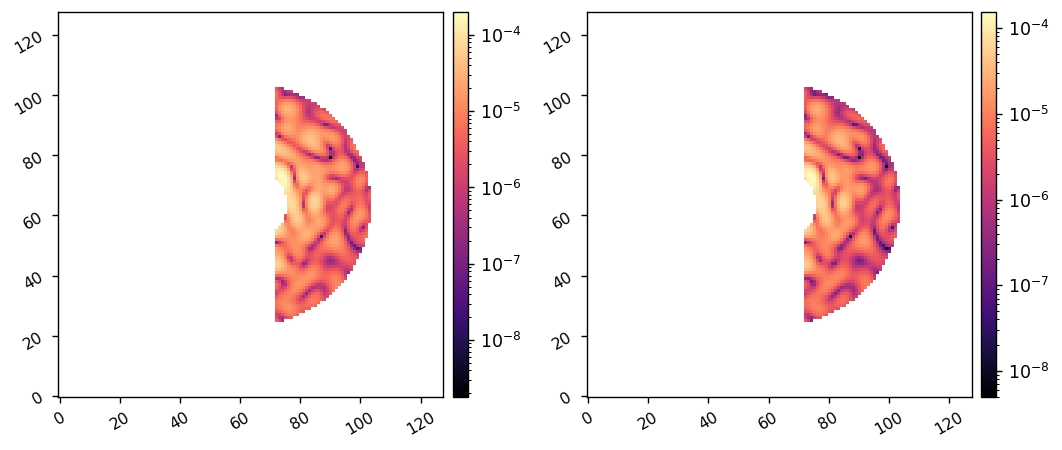

In [23]:
I_est = xp.abs(est)**2

imshow2(model_im*control_mask, I_est, lognorm=True)

In [37]:
pwp_fun = pwp.run_pwp_bp

probe_amp=5e-9
pwp_params = {
    'control_mask':control_mask, 
    'probes':probe_modes*probe_amp, 
    'jacobian':jac, 
    'embedded_controller':embedded_controller,
    'plot':False, 
    'plot_est':True
}

In [43]:
subprocess.Popen(["/home/apra/Projects/P5040/P5040_test_software/EFC/bin/EFC_local"])

<Popen: returncode: None args: ['/home/apra/Projects/P5040/P5040_test_softwa...>

In [43]:
reg = 1e-1
# control_matrix = efc_utils.TikhonovInverse(jac, rcond=reg)
control_matrix = efc_utils.beta_reg(jac, -5)

embedded_controller.send_jacobian(jac)
embedded_controller.send_command_matrix(control_matrix)

Beginning closed-loop EFC.
	Running iteration 7/9.
Using PWP to estimate electric field


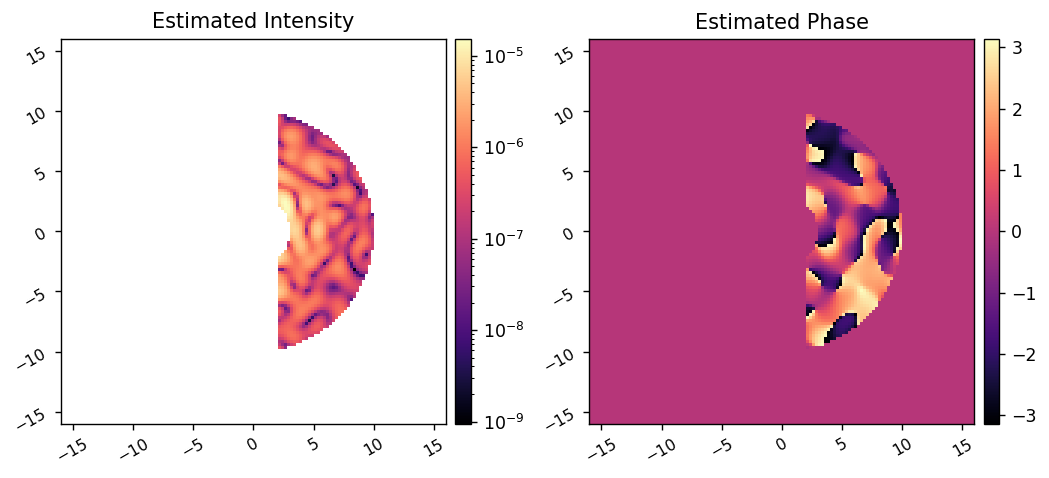

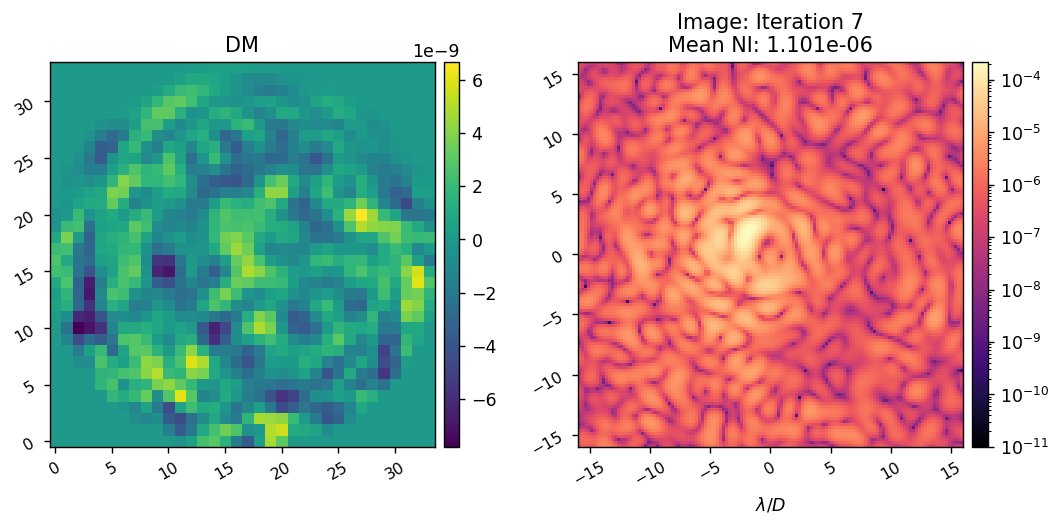

	Running iteration 8/9.
Using PWP to estimate electric field


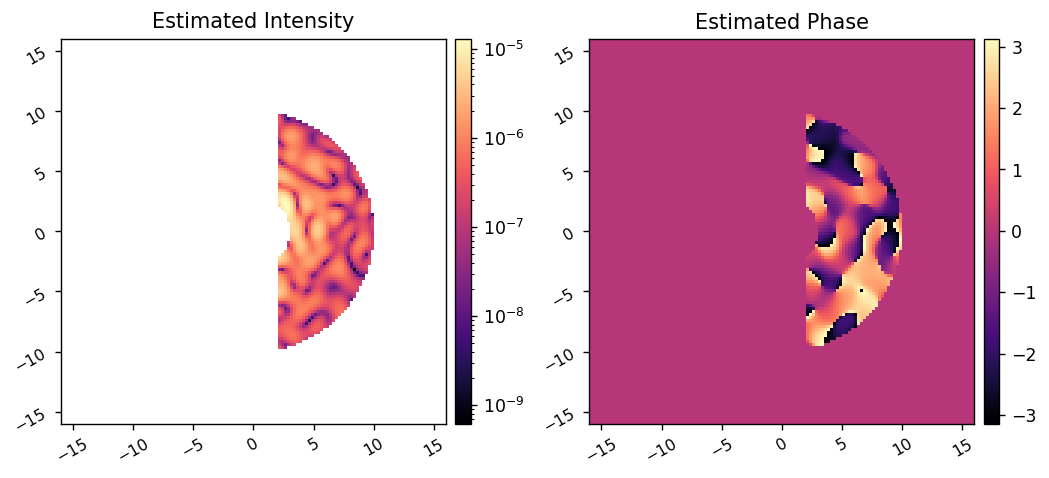

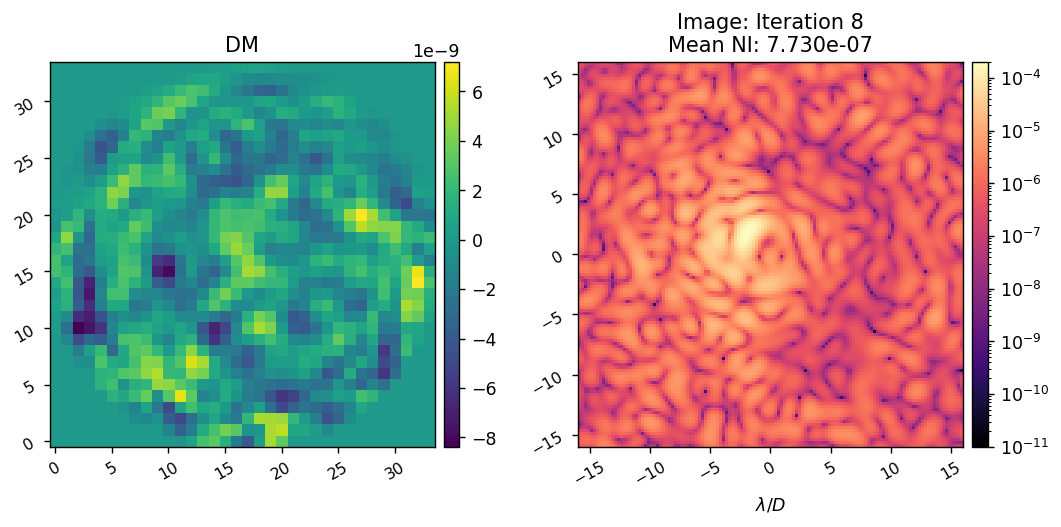

	Running iteration 9/9.
Using PWP to estimate electric field


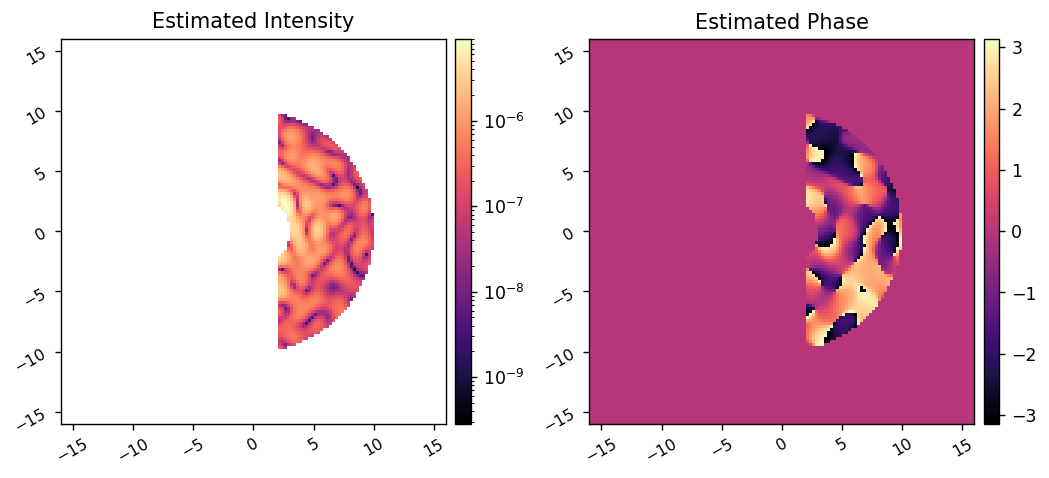

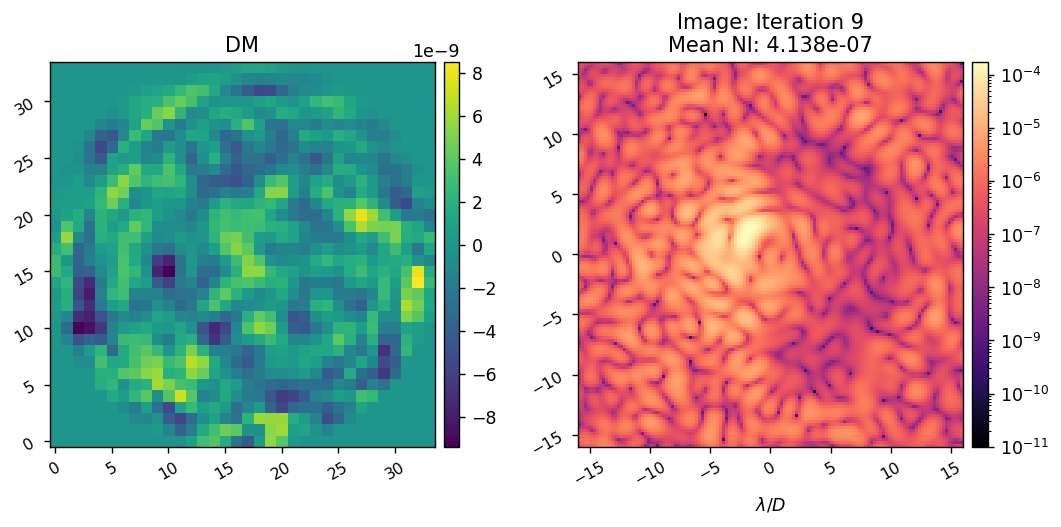

EFC completed in 35.151 sec.


In [44]:
reload(efc)
images, estimates, dm_commands = efc.run(model, embedded_controller,
                                         poke_modes,
                                         control_matrix,
                                         control_mask, 
                                        est_fun=pwp_fun,
                                        est_params=pwp_params,
                                        loop_gain=0.1, 
                                        leakage=0.0,
                                        iterations=3, 
                                        plot_all=True, 
                                        plot_current=True,
                                        plot_sms=False,
                                        plot_radial_contrast=False,
                                        old_images=images,
                                        # old_fields=estimates,
                                        old_commands=dm_commands,
                                            )

In [50]:
control_matrix = efc_utils.beta_reg(jac, -2.5)

embedded_controller.send_jacobian(jac)
embedded_controller.send_command_matrix(control_matrix)

Beginning closed-loop EFC.
	Running iteration 19/21.
Using PWP to estimate electric field


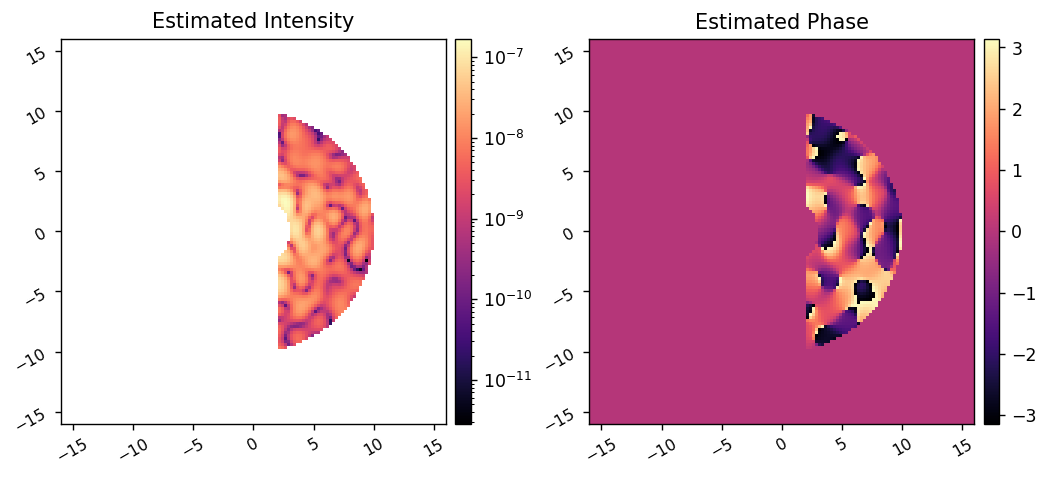

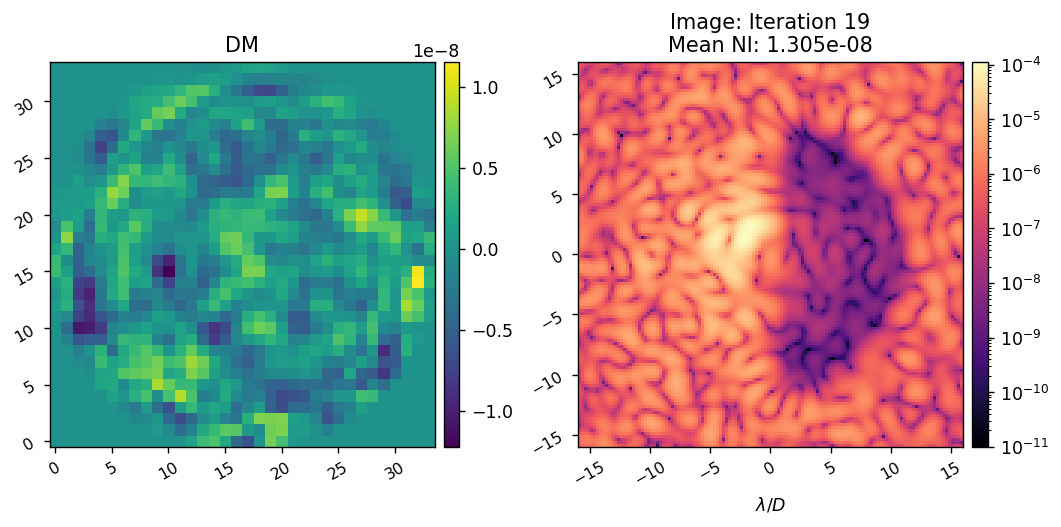

	Running iteration 20/21.
Using PWP to estimate electric field


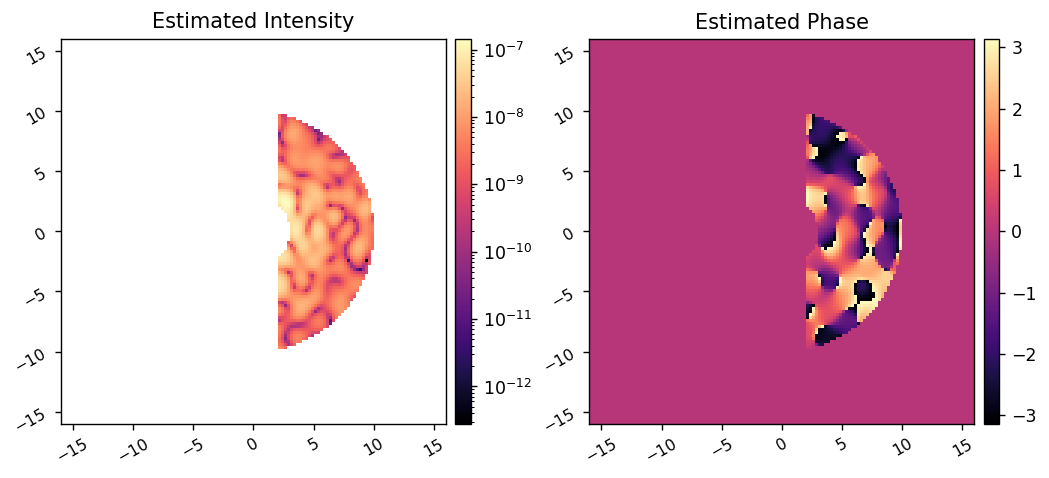

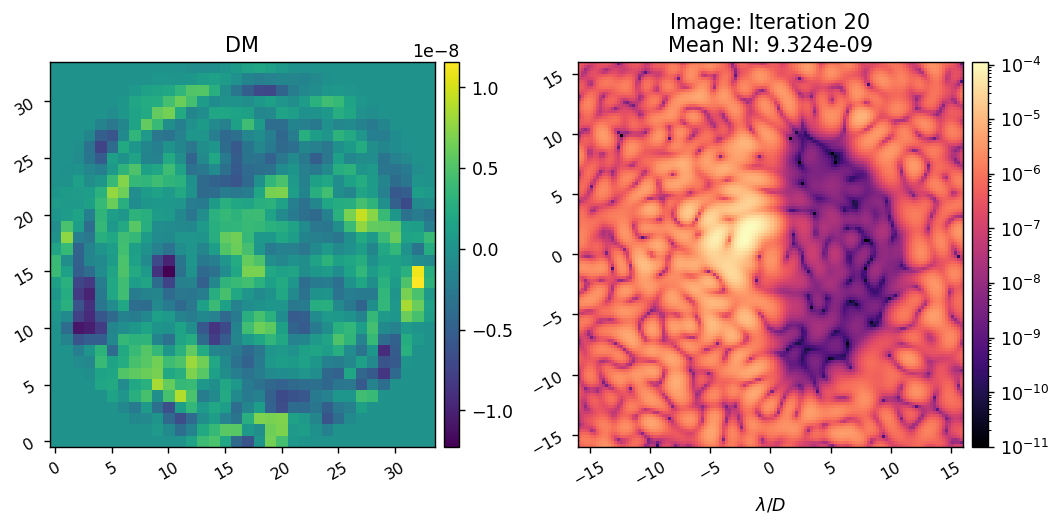

	Running iteration 21/21.
Using PWP to estimate electric field


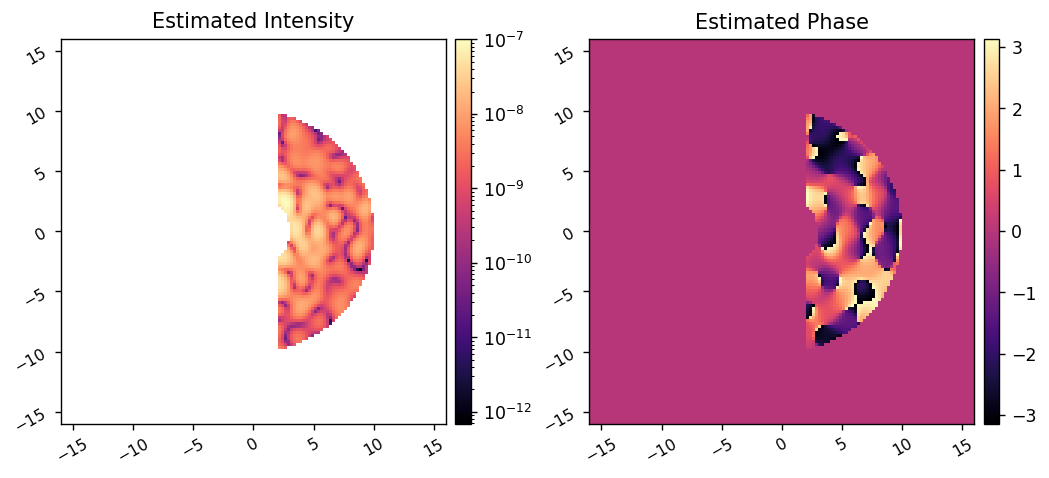

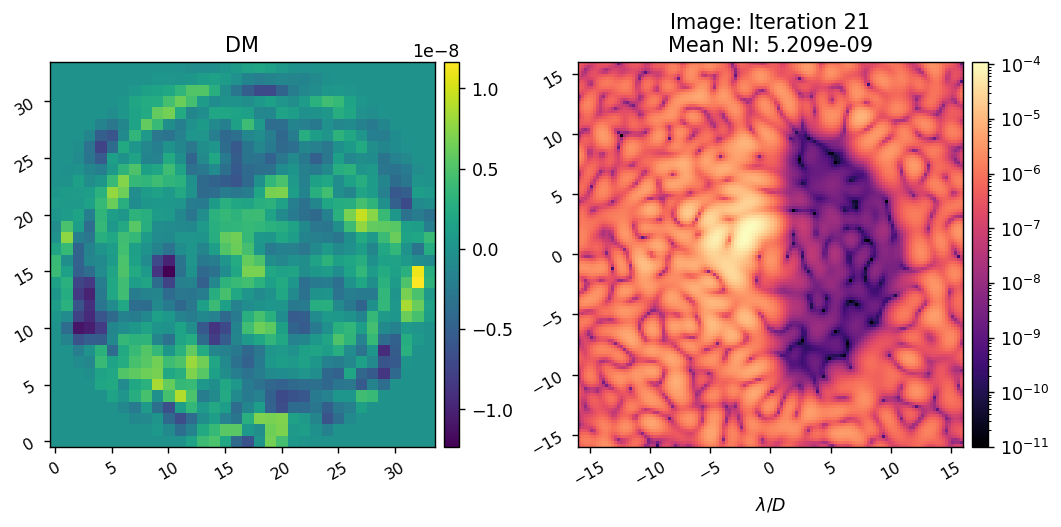

EFC completed in 35.321 sec.


In [51]:
reload(efc)
images, estimates, dm_commands = efc.run(model, embedded_controller,
                                         poke_modes,
                                         control_matrix,
                                         control_mask, 
                                        est_fun=pwp_fun,
                                        est_params=pwp_params,
                                        loop_gain=0.1, 
                                        leakage=0.0,
                                        iterations=3, 
                                        plot_all=True, 
                                        plot_current=True,
                                        plot_sms=False,
                                        plot_radial_contrast=False,
                                        old_images=images,
                                        # old_fields=estimates,
                                        old_commands=dm_commands,
                                            )

In [54]:
control_matrix = efc_utils.beta_reg(jac, -2.5)

embedded_controller.send_jacobian(jac)
embedded_controller.send_command_matrix(control_matrix)

Beginning closed-loop EFC.
	Running iteration 28/30.
Using PWP to estimate electric field


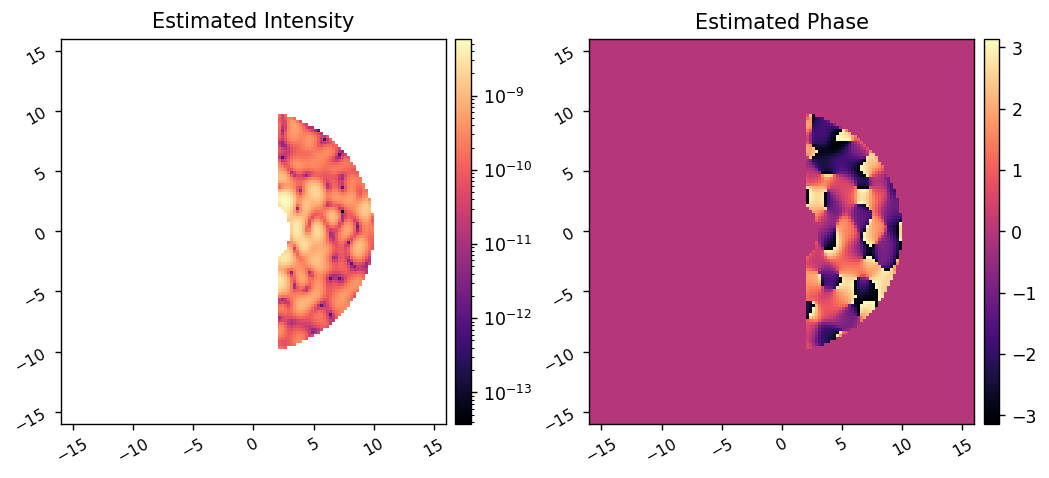

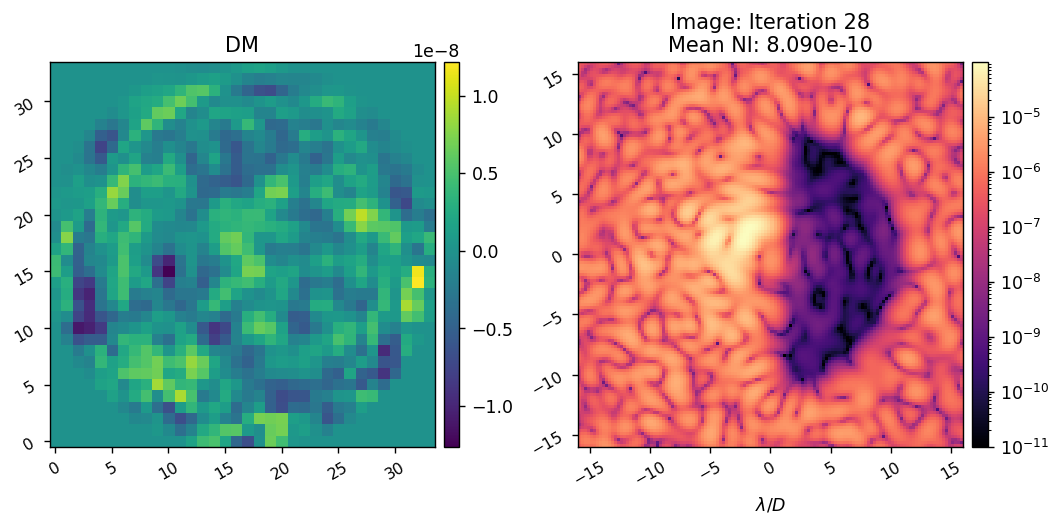

	Running iteration 29/30.
Using PWP to estimate electric field


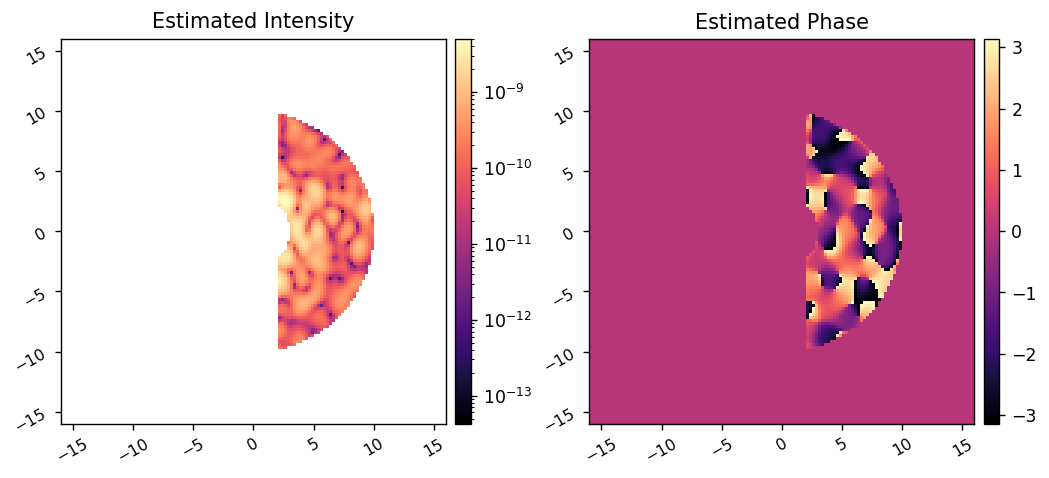

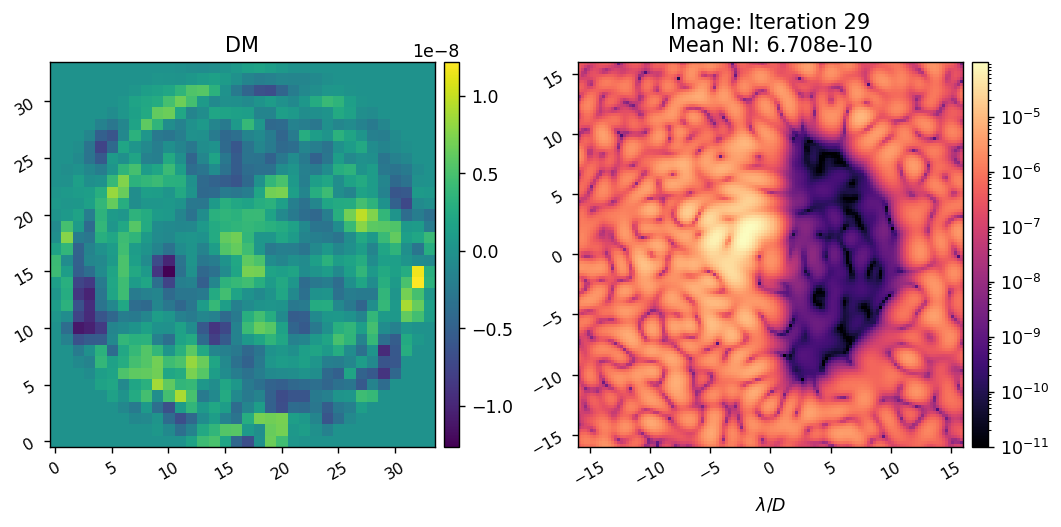

	Running iteration 30/30.
Using PWP to estimate electric field


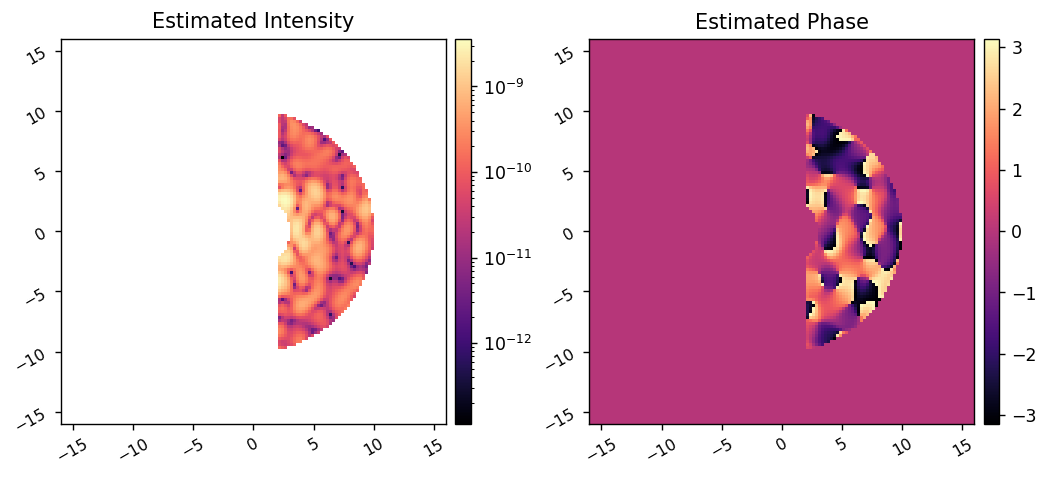

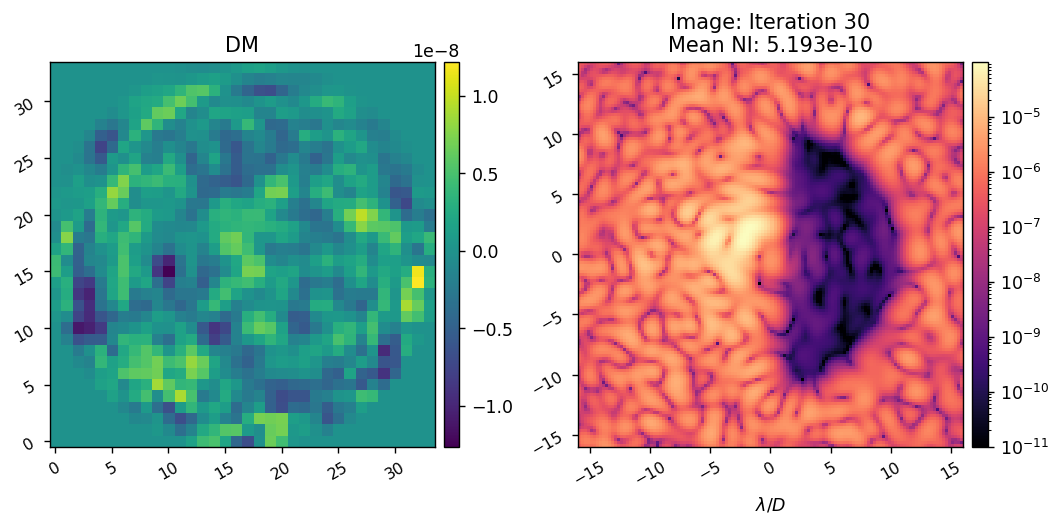

EFC completed in 35.180 sec.


In [56]:
reload(efc)
images, estimates, dm_commands = efc.run(model, embedded_controller,
                                         poke_modes,
                                         control_matrix,
                                         control_mask, 
                                        est_fun=pwp_fun,
                                        est_params=pwp_params,
                                        loop_gain=0.1, 
                                        leakage=0.0,
                                        iterations=3, 
                                        plot_all=True, 
                                        plot_current=True,
                                        plot_sms=False,
                                        plot_radial_contrast=False,
                                        old_images=images,
                                        # old_fields=estimates,
                                        old_commands=dm_commands,
                                            )